# 初始化

In [1]:
# 初始化，请填写appname参数，其中包含你的用户名和本次使用数据集
%run spark_semmed_init.py --appname=MarioZZJ_SemMedDB

可以在新标签页访问上面的 Spark UI 链接，查看任务执行进度，也可以去 Spark UI 总页面，查看多个 app 的并行运行情况。

# 查看 schema

此时我们获取了 6 个 pyspark.sql.dataframe.DataFrame 对象，分别对应 6 张表，可以使用 showSchema() 方法查看字段。

6 个对象的变量名：`Citations`, `Entity`, `Predication`, `PredicationAux`, `Sentence`, `GenericConcept`

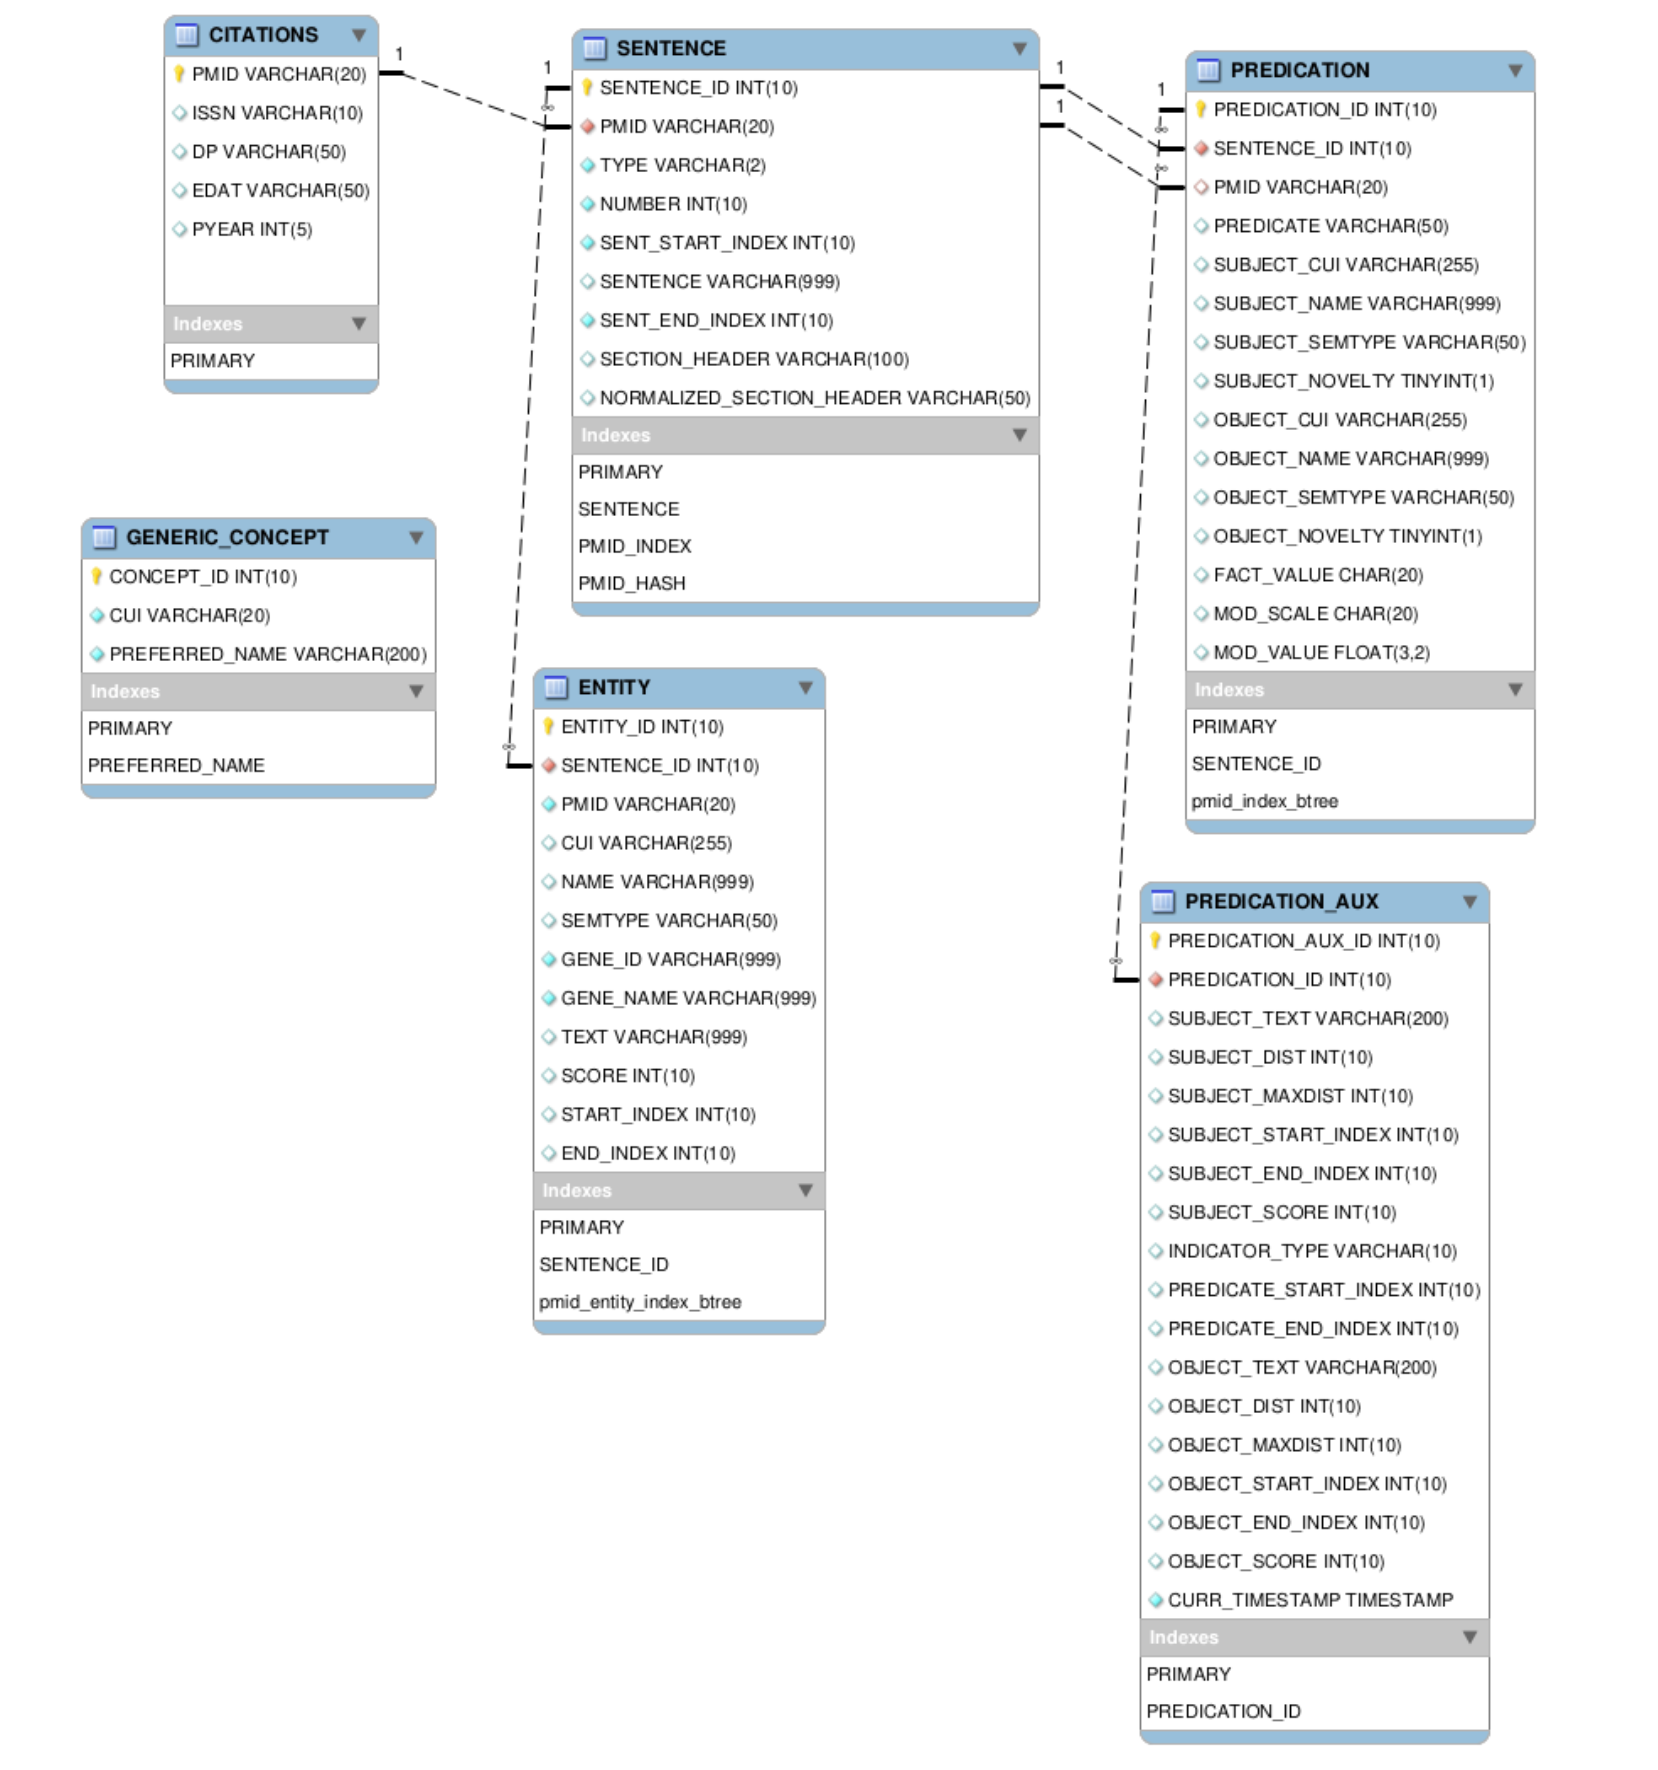

字段详细信息可以查看 [官网](https://lhncbc.nlm.nih.gov/ii/tools/SemRep_SemMedDB_SKR/dbinfo.html)

In [2]:
Predication.printSchema()

root
 |-- predication_id: integer (nullable = true)
 |-- sentence_id: integer (nullable = true)
 |-- pmid: integer (nullable = true)
 |-- predicate: string (nullable = true)
 |-- subject_cui: string (nullable = true)
 |-- subject_name: string (nullable = true)
 |-- subject_semtype: string (nullable = true)
 |-- subject_novelty: integer (nullable = true)
 |-- object_cui: string (nullable = true)
 |-- object_name: string (nullable = true)
 |-- object_semtype: string (nullable = true)
 |-- object_novelty: integer (nullable = true)
 |-- fact_value: string (nullable = true)
 |-- mod_scale: string (nullable = true)
 |-- mod_value: float (nullable = true)



# 案例：检索

In [3]:
sample = Citations.filter(
    Citations.pyear == 2023 # filter() 过滤中填入表达式，可以用`==`精确匹配，也可用 like() 模糊匹配
    ).limit(10).toPandas()  # 建议探索时多用 limit，减少对资源的占用;toPandas() 转化为 dataframe，直接在 notebook 展示
sample

,pmid,issn,dp,edat,pyear
0,33031034,1939-3539,2023 Jun,2020-10-8,2023
1,33036828,1436-2023,2023 May,2020-10-10,2023
2,33044930,1939-3539,2023 Jun,2020-10-12,2023
3,33046277,1873-4588,2023 Jan,2020-10-13,2023
4,33047940,1827-1669,2023 Feb,2020-10-13,2023
5,33048760,2162-2388,2023 Apr,2020-10-13,2023
6,33048762,2162-2388,2023 Apr,2020-10-13,2023
7,33050971,1741-203X,2023 May,2020-10-14,2023
8,33052186,1062-9769,2023 Feb,2020-10-14,2023
9,33052851,1939-3539,2023 Jun,2020-10-14,2023


# 案例：列裁剪

等价于 `SELECT`，仅取出需要的列，减少不必要的资源占用

In [4]:
sample = Predication.filter(Predication.pmid == 33031034).select(Predication.subject_cui, Predication.predicate, Predication.object_cui).toPandas()
sample

,subject_cui,predicate,object_cui
0,C0037290,PROCESS_OF,C0027361


# 案例：表连接

等价于 `JOIN`，注意连接的先后顺序

In [5]:
sample = Predication.filter(
    Predication.pmid == 16541409
    ).select(
        Predication.subject_cui, Predication.predicate, Predication.object_cui
        ).join(GenericConcept, # 第一个参数：连接的表
    Predication.subject_cui == GenericConcept.cui, # 第二个参数：连接依据，where
    how = 'inner') # 第三个参数：连接方式，这里为 inner join
sample.toPandas() # 如果没有调用 toPandas()、show()等，变量仅保留计算图，并未实际开始计算

,subject_cui,predicate,object_cui,concept_id,cui,preferred_name
0,C0003043,LOCATION_OF,C0013202,1985,C0003043,Animalia


# 案例：保存数据

有时我们需要将中间结果进行保存，如果数据量较小，可以对 toPandas() 的 dataframe 对象直接使用 pandas 库的方法保存，而当数据量较大时，建议使用 spark 的 write() 方法保存为多个文件，减小内存和运算压力。

In [6]:
sample = Citations.filter(Citations.pyear==2023).write.csv("./data/sample2023", header=True, mode="overwrite") # header 为 True 时，每个子文件均包含表头（建

# 案例：读取数据

对于上述保存的分片数据，同样可以使用 spark 的 read() 方法将其读取为 pyspark.sql.dataframe.DataFrame 对象，进行后续操作。

In [7]:
sample = spark.read.csv("./data/sample2023", header=True, inferSchema=True)
print(type(sample))
sample.limit(10).toPandas()

<class 'pyspark.sql.dataframe.DataFrame'>


,pmid,issn,dp,edat,pyear
0,36585767,1365-313X,2023 Jan,2022-12-31,2023
1,36585791,2052-1707,2023 Feb,2022-12-31,2023
2,36585794,2052-1707,2023 Feb,2022-12-31,2023
3,36585801,2191-0251,2023 Jan 02,2022-12-31,2023
4,36585811,2633-1462,2023 Jan,2022-12-31,2023
5,36585818,2046-3758,2023 Jan,2022-12-31,2023
6,36586105,2191-0200,2023 Jan 02,2022-12-31,2023
7,36586131,1619-3997,2023 Jan 02,2022-12-31,2023
8,36586135,1467-8519,2023 Jan,2022-12-31,2023
9,36586137,1525-1594,2023 Jan,2022-12-31,2023


# 重要：释放 session

请在使用资源时保持良好习惯，结束使用时执行下列语句对占用资源进行释放；或 shutdown notebook 也可对资源进行释放。

In [8]:
spark.sparkContext.stop()
spark.stop()